#  Logistic Regression and Classification Error Metrics

# Alunos:
    - Leonardo Leite Meira - 20183005069
    - Rafael Silvério de Sá Lopes - 20183012994

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['.']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

5340    0
6017    4
7118    4
2361    5
4287    0
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

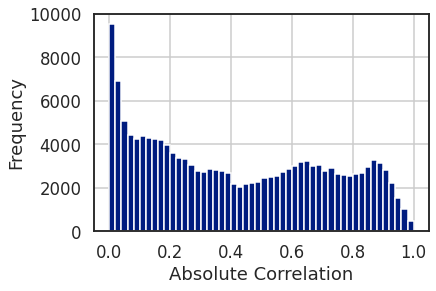

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

array([[-232.7756002 ,   37.95392659,   52.31191586, ..., 2090.73334833,
        -849.27146842, -214.42279089],
       [-687.57726164, -257.34988411,  109.92618764, ..., -233.15297675,
        -329.75818698, -250.03761042],
       [ 284.22614846,  198.22869144,  211.42364094, ..., -837.82965779,
         641.9351792 ,   40.50713493],
       [  29.82548382,  -46.36790954,    3.96756888, ..., -375.03289766,
          64.98501201,  203.82755087],
       [ 427.13207395,   92.1777491 ,    7.26276413, ..., -738.82286126,
         -45.99250164,  -19.33523486],
       [ 179.16915561,  -24.64257348, -384.89207745, ...,   94.10504513,
         518.10196583,  239.46095038]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [20]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                               \
              0           1            2           3           4           5   
381  -66.442169   -7.274305    51.949299  -83.332113  410.979196 -305.879909   
390  -85.078449   -5.988962    45.243286   71.955727  193.596118 -219.727720   
463   41.710498  122.301747   156.050002  117.787343 -418.297769  -19.551820   
476   37.339245  101.168762   187.656158 -156.129543  -18.743458 -151.291164   
69   193.233598 -293.483239   -54.342486  443.715934  179.370920 -468.494727   
144 -158.904955 -209.891543  -292.577880  134.561974  177.826446  348.985959   
534  -23.168949   64.579058    47.425567 -103.434028  150.745548 -136.147196   
2     52.311916  109.926188   211.423641    3.967569    7.262764 -384.892077   
121 -108.327328 -772.654050  1046.534762  113.449070    2.061464 -281.063918   
68   -47.549424 -164.496416  -312.959478 -147.855937  726.323695  -53.462439   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
381 -0.015669  0.000000  0.000000 -0.028551  0.593357 -1.134194 -0.020752   
390 -0.000041  0.000000  0.000000 -0.178885  0.193137 -0.547342 -0.026653   
463  0.000000  0.261877  0.315564  0.357609 -0.252024  0.413206 -0.016308   
476 -0.040569  0.207697  0.129165  0.000000  0.000000  0.410406 -0.015385   
69   0.000000  0.000000  0.000000  1.223624  0.000000 -2.159049  0.188957   
144  0.000000  0.000000  0.028605  0.896523  0.000000  0.000000  0.090100   
534  0.000000  0.065994  0.000000  0.061201  0.328577 -0.432662 -0.014103   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.036884   
121  0.000000 -0.697787  4.865430  3.526399 -0.085749 -0.991030 -0.115538   
68   0.000000 -1.483376  0.000000 -0.351998  0.619476 -0.542040  0.017810   

                                                       
            1         2         3         4         5  
381 -0.046282 -0.035300 -0.011866  0.566373 -0.452173  
390 -0.015256 -0.013645  0.016633  0.203954 -0.165034  
463  0.013475 -0.010624  0.216028 -0.313267  0.110695  
476 -0.007971  0.017722  0.025853 -0.010829 -0.009389  
69  -0.150086 -0.066996  0.561373  0.098133 -0.631382  
144 -0.097368 -0.162793  0.056330  0.010150  0.103581  
534  0.062038 -0.106541 -0.029408  0.165877 -0.077863  
2   -0.027263  0.224286  0.006178 -0.001595 -0.238490  
121 -1.062529  1.351037  0.201596 -0.007098 -0.367468  
68  -0.360657  0.063228 -0.100648  0.516938 -0.136671

Prepare six separate plots for each of the multi-class coefficients.

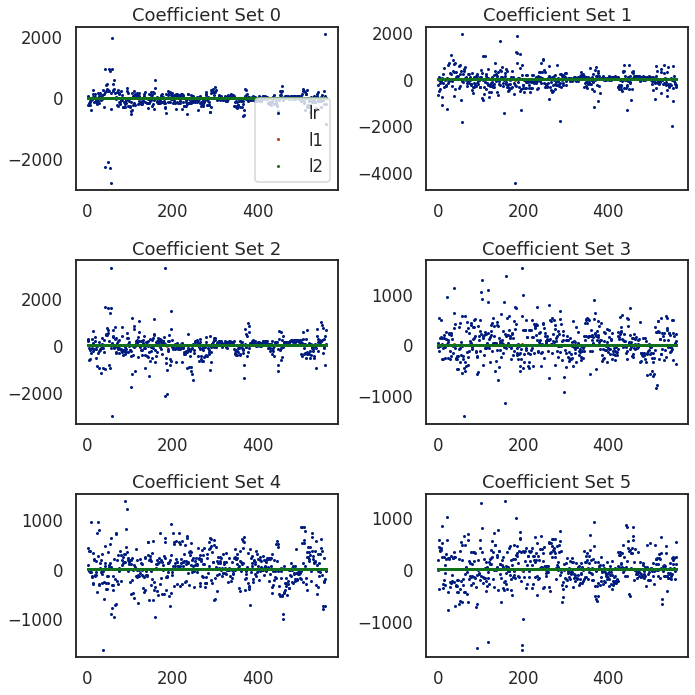

In [21]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [22]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [23]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998910,0.999998
1,1.0,0.999526,0.999654
2,1.0,0.995622,0.998873
3,1.0,0.999171,0.997833
4,1.0,0.999921,0.999300


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [25]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.981896,0.983835,0.983485
recall,0.981877,0.983819,0.983495
fscore,0.981884,0.983815,0.983488
accuracy,0.981877,0.983819,0.983495
auc,0.989014,0.990144,0.989983


## Question 8

Display or plot the confusion matrix for each model.

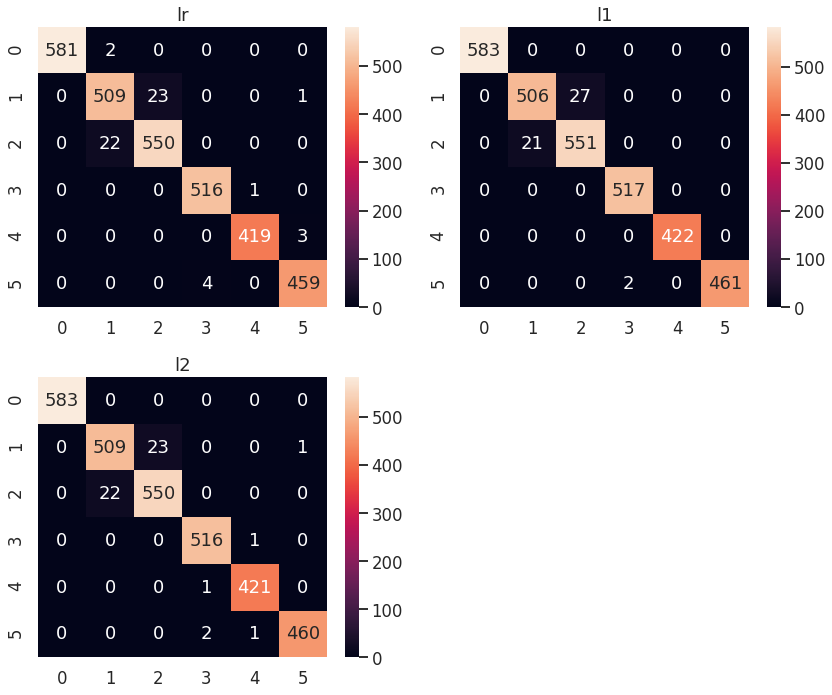

In [26]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(7209, 561)
(7209, 50)
(3090, 561)


In [42]:
y_train_new.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [43]:
y_test_new.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

 Repeat Model building with new training data after removing higly correlated columns

In [28]:
# Try standard, L1 and L2 Logistic regression

In [44]:
# Standard logistic regression
lr = LogisticRegression(max_iter=100000, penalty='none').fit(X_train_new, y_train_new)
lr.coef_

array([[-1.53870774e+00, -1.79890340e+00, -1.41820743e+01,
         5.54286091e+00, -9.17899055e+00, -2.59971954e+01,
        -1.48249916e+01, -3.26873058e+01, -3.09350751e+01,
         2.61390497e+00,  3.85738143e+00,  1.60841119e+00,
         4.49415286e-01, -5.58427050e+00, -3.34780525e+00,
         2.66421646e-01, -2.02612677e+00, -1.64324790e-01,
         3.72603501e+00,  5.46660164e+00,  3.72603501e+00,
         4.80190589e+00,  3.72603501e+00,  5.46660164e+00,
         3.72603501e+00,  4.80190589e+00, -1.79029514e+00,
         1.18044294e+00, -4.21878674e-01, -5.51923924e+00,
        -7.14130983e-01, -4.61333088e+00, -1.98593416e+00,
        -1.66807326e+00, -4.57832274e+00,  1.63714252e+00,
        -1.42730956e+01, -5.68899289e+00, -3.34287957e+00,
        -2.37683033e+00,  3.72299156e+00, -6.08115021e+00,
        -6.83630072e-01, -2.40287112e+00, -5.03210192e+00,
        -6.26247340e+00, -1.03671118e+00, -1.59605813e+00,
        -2.80401922e+00,  2.38654386e+01],
       [ 8.67

In [46]:
# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=10000).fit(X_train_new, y_train_new)

In [29]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [47]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [49]:
# Combine all the coefficients into a dataframe for comparison
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                           \
            0          1          2           3          4           5   
31  -4.613331   2.597067  -5.982316   -0.062909   9.043089   -0.981600   
5  -25.997195  62.980027 -49.014184 -172.543549  19.159057  165.415844   
42  -0.683630   2.185728  -0.879843   -6.005804   2.507301    2.876248   
1   -1.798903  -1.075853   0.730434    5.983896  -4.501543    0.661970   
3    5.542861  -9.464360  11.027657  -44.945010  21.274732   16.564120   
29  -5.519239 -29.357391  25.834967   52.785439 -29.549158  -14.194618   
24   3.726035   0.122901  -0.507726    5.240368  -4.586088   -3.995489   
45  -6.262473   1.222314   2.095574    8.360373  -2.359969   -3.055819   
18   3.726035   0.122901  -0.507726    5.240368  -4.586088   -3.995489   
39  -2.376830  -1.764240  -3.185853    9.134692   6.265631   -8.073399   

         l1                                                                l2  \
          0          1          2          3          4          5          0   
31  0.00000   0.000000  -3.890533   0.163961   9.615126  -2.943009  -0.271687   
5  -2.66323  46.450621  10.326087  -0.462713  -7.398072  16.353420 -11.785093   
42  0.00000   2.338534  -2.700371  -6.791830   2.109441   2.561834  -0.042369   
1   0.00000   4.822283   0.000000  11.064862  -4.269852  -1.061659   0.251840   
3   0.00000  -4.249362   0.000000 -57.263333  13.009228   8.906416   1.801393   
29  0.00000   0.000000  -2.785542  30.512260   6.028164  -4.778560  -0.441841   
24  0.00000  -0.288591   0.816092   8.294947  -1.465875  -0.264640   1.428509   
45  0.00000  -0.217213   0.159473   5.517992  -1.549274  -2.252040  -1.508814   
18  0.00000  -0.957833   0.708591   8.047757  -1.191146  -0.541122   1.428509   
39  0.00000   0.029206  -1.832655  10.846605  10.761488 -10.218070  -0.836945   

                                                           
            1          2          3          4          5  
31  -1.355029  -1.466848  -0.396576   6.181870  -2.691731  
5   35.213015 -27.661618 -23.367051  -2.882726  30.483473  
42   2.309539  -0.672476  -5.799776   2.009278   2.195805  
1   -1.165910   1.065495   4.750204  -4.772082  -0.129547  
3   -4.599284   6.655539 -35.341165  17.557996  13.925522  
29  -6.293564   3.341353  11.632410  -2.962298  -5.276060  
24  -0.347452   0.824513   4.018414  -3.182242  -2.741742  
45  -0.624747   0.171151   6.953973  -2.134987  -2.856576  
18  -0.347452   0.824513   4.018414  -3.182242  -2.741742  
39  -1.040298  -2.357955   7.061326   5.564870  -8.390998

Prepare six separate plots for each of the multi-class coefficients.

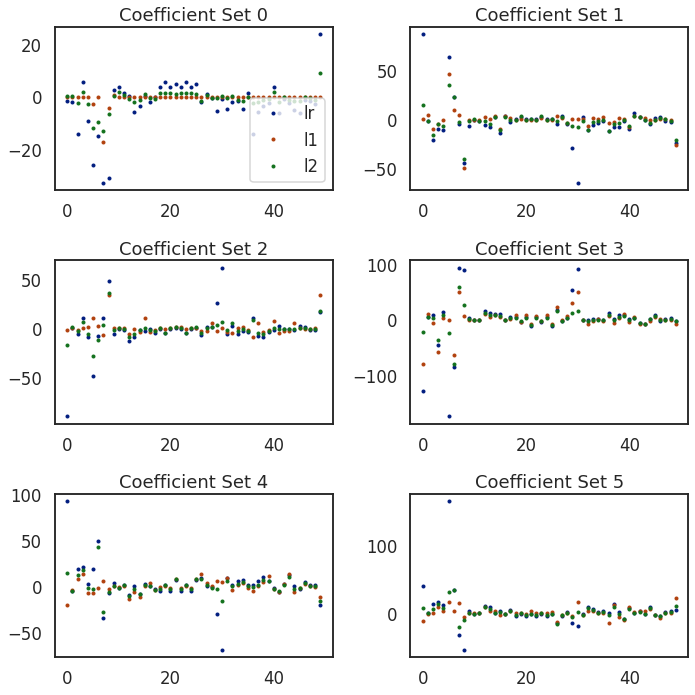

In [59]:
# try the plots
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=3.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+ str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [51]:
# Predict the class and the probability for each

y_pred_new = list()
y_prob_new = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [52]:
y_prob_new.head()

,lr,l1,l2
0,0.999999,0.997239,0.999993
1,0.999857,0.998126,0.999866
2,0.999998,0.984704,0.999982
3,0.878535,0.863664,0.877469
4,1.000000,0.999995,0.999999


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [53]:
# Calculate the error metrics as listed above

metrics_new = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred_new[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred_new[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred_new[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test_new, y_pred_new[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)

In [54]:
#Run the metrics
metrics_new

,lr,l1,l2
precision,0.937076,0.937646,0.936978
recall,0.936893,0.937540,0.936893
fscore,0.936902,0.937546,0.936879
accuracy,0.936893,0.937540,0.936893
auc,0.962166,0.962461,0.962153


## Question 13

Display or plot the confusion matrix for each model.

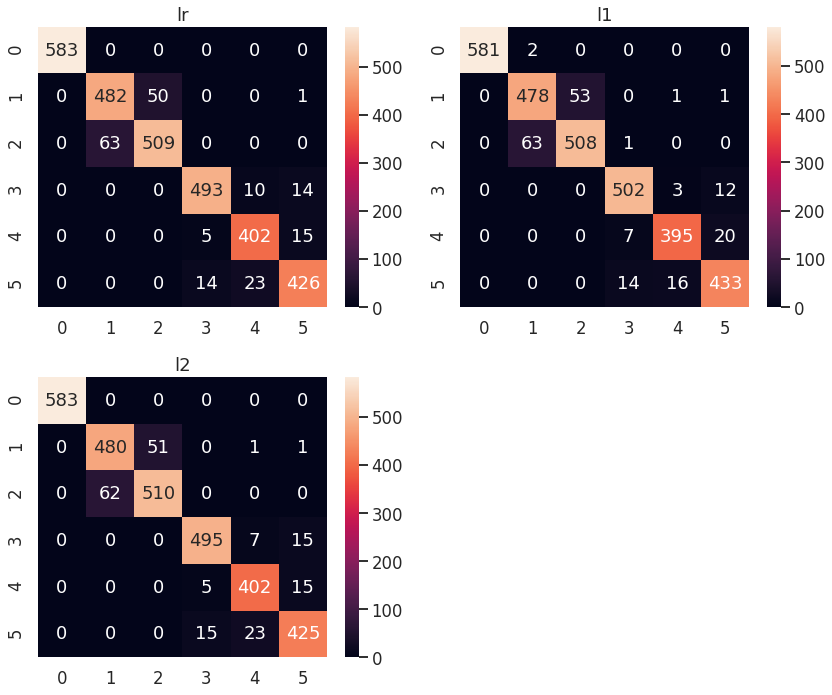

In [55]:
#plot the confusion matrix

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [36]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [56]:
metrics

,lr,l1,l2
precision,0.981896,0.983835,0.983485
recall,0.981877,0.983819,0.983495
fscore,0.981884,0.983815,0.983488
accuracy,0.981877,0.983819,0.983495
auc,0.989014,0.990144,0.989983


In [57]:
metrics_new

,lr,l1,l2
precision,0.937076,0.937646,0.936978
recall,0.936893,0.937540,0.936893
fscore,0.936902,0.937546,0.936879
accuracy,0.936893,0.937540,0.936893
auc,0.962166,0.962461,0.962153


Para todos os novos modelos as métricas de erro sofreram uma redução, porém a redução do tempo de treino e de custo foi bem expressiva, dado que as features sofreram grande redução.

In [2]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

De acordo com as matrizes de confusão, pode-se perceber que o novo modelo teve sua qualidade de classificação reduzida, o que explica a piora nas métricas de erro, embora os resultados ainda sejam satisfatórios.
Uma das causa pode ser que os erros foram acentuados com a retirada das features no novo modelo, já que os erros estão localizados quase nas mesmas regiões, embora em maior quantidade.